In [17]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from sklearn.cluster import KMeans

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.18.1                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


In [18]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [19]:
neighborhoods_data = newyork_data['features']

In [20]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [21]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [22]:
ny_data = neighborhoods.copy()

In [23]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Define Foursquare Credentials and Version

In [24]:
CLIENT_ID = 'APVCKB3ZPAVXZKXZLBT4Y4G1A3DJNGDFHDF4YO4C2BLENF4X' # your Foursquare ID
CLIENT_SECRET = 'HT3GAE5BYQ4MWKDXPR2EIGMZF2GKHYKVHP123ORTQ5125IP0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: APVCKB3ZPAVXZKXZLBT4Y4G1A3DJNGDFHDF4YO4C2BLENF4X
CLIENT_SECRET:HT3GAE5BYQ4MWKDXPR2EIGMZF2GKHYKVHP123ORTQ5125IP0


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
names = ny_data['Neighborhood']
latitudes = ny_data['Latitude']
longitudes = ny_data['Longitude']

# Get all venues inside each neighborhood
# ny_venues = getNearbyVenues(names, latitudes, longitudes, radius=500)

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

KeyError: 'groups'

In [27]:
ny_restaurant = ny_venues[ny_venues['Venue Category'].str.contains('Restaurant')] # only get restaurants venue

In [28]:
# Find out unique Venue in ny_venues
ny_unique_venues = ny_restaurant.copy() # make a copy
ny_unique_venues = ny_unique_venues.drop_duplicates('Venue') # drop duplicate venue between neighborhoods
ny_unique_venues.reset_index(inplace=True) # create a index column
ny_unique_venues.drop('index', inplace=True, axis=1)  # drop that index column
# print(len(ny_unique_venues))
ny_unique_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,Restaurant
1,Eastchester,40.887556,-73.827806,Fish & Ting,40.885539,-73.829151,Caribbean Restaurant
2,Eastchester,40.887556,-73.827806,Dyre Fish Market,40.889318,-73.831453,Seafood Restaurant
3,Eastchester,40.887556,-73.827806,Golden Krust Caribbean Bakery and Grill,40.888543,-73.831278,Caribbean Restaurant
4,Eastchester,40.887556,-73.827806,McDonald's,40.885636,-73.826840,Fast Food Restaurant


In [29]:
tem_neighborhoods = neighborhoods.copy().drop_duplicates('Neighborhood') # drop duplicate neighborhood

In [30]:
# merge tem_neighborhoods with ny_unique_venues on Neighborhood
my_ny = tem_neighborhoods.join(ny_unique_venues.set_index('Neighborhood'), on='Neighborhood')
# Replace NaN value in 'Venue' by 0
my_ny['Venue'].replace(np.nan, 0, inplace=True) 

In [31]:
# Only get rows do not have 0  in 'Venue'
my_ny = my_ny[my_ny['Venue'] != 0]
filter_columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
my_ny_filtered = my_ny.copy()[filter_columns]
print(len(my_ny))


2256


In [32]:
my_ny_filtered.sort_values(by='Borough', inplace=True)
my_ny_filtered.reset_index(inplace=True)
my_ny_filtered.drop('index', inplace=True, axis=1)
my_ny_filtered.head()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,Restaurant
1,Bronx,Belmont,40.857277,-73.888452,Arthur Avenue Cafe,40.854068,-73.888838,Italian Restaurant
2,Bronx,Belmont,40.857277,-73.888452,Bella Pizza,40.854830,-73.890410,Italian Restaurant
3,Bronx,Belmont,40.857277,-73.888452,Golden City,40.854018,-73.889059,Restaurant
4,Bronx,Belmont,40.857277,-73.888452,Las Chatas,40.853850,-73.889492,Mexican Restaurant


In [33]:
def draw_res_map(borough):
    address = borough + ', New York City, NY'

    geolocator = Nominatim()
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    ny_head_unique_venues = my_ny_filtered.copy()[my_ny_filtered['Borough'] == borough]

    # create map of New York using latitude and longitude values
    map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10,)

    from folium import plugins
    res_group = plugins.MarkerCluster().add_to(map_newyork)

    # add markers to map
    for lat, lng, venue, category in zip(ny_head_unique_venues['Venue Latitude'], ny_head_unique_venues['Venue Longitude'], ny_head_unique_venues['Venue'], ny_head_unique_venues['Venue Category']):
        label = '{}, {}'.format(venue, category)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            ).add_to(map_newyork)  

    return map_newyork

### Restaurants in Bronx

In [34]:
draw_res_map('Bronx')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


### Restaurants in Manhattan

In [35]:
draw_res_map('Manhattan')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


### Restaurants in Brooklyn

In [36]:
draw_res_map('Brooklyn')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


### Restaurants in Queens

In [37]:
draw_res_map('Queens')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


### Restaurants in Staten Island

In [38]:
draw_res_map('Staten Island')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


### Get total restaurants per borough

In [39]:
my_ny_filtered.head()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,Restaurant
1,Bronx,Belmont,40.857277,-73.888452,Arthur Avenue Cafe,40.854068,-73.888838,Italian Restaurant
2,Bronx,Belmont,40.857277,-73.888452,Bella Pizza,40.854830,-73.890410,Italian Restaurant
3,Bronx,Belmont,40.857277,-73.888452,Golden City,40.854018,-73.889059,Restaurant
4,Bronx,Belmont,40.857277,-73.888452,Las Chatas,40.853850,-73.889492,Mexican Restaurant


In [40]:
ny_unique_venues = my_ny_filtered.copy().groupby(['Borough'])['Venue'].count()


In [41]:
ny_unique_venues = pd.DataFrame(ny_unique_venues)
ny_unique_venues.reset_index(inplace=True)
ny_unique_venues.head()

,Borough,Venue
0,Bronx,214
1,Brooklyn,558
2,Manhattan,854
3,Queens,500
4,Staten Island,130


### Find out number of people and restaurant in each borough

In [42]:
ny_bar = ny_unique_venues.copy()

In [43]:
# Input population data and square/km 
ny_bar['Population'] = ['1,471,160','2,648,771','1,664,727','2,358,582','479,458']
ny_bar.columns = ['Borough', 'Num_of_restaurant','Population']

ny_bar.set_index('Borough', inplace=True)
ny_bar.index.name = None
ny_bar

,Num_of_restaurant,Population
Bronx,214,"1,471,160"
Brooklyn,558,"2,648,771"
Manhattan,854,"1,664,727"
Queens,500,"2,358,582"
Staten Island,130,"479,458"


In [44]:
# Get percentage of each column to normalize data
ny_bar['Num_of_restaurant'] = round(ny_bar['Num_of_restaurant'].astype(float) / sum(ny_bar['Num_of_restaurant'].astype(float)) * 100, 2)
ny_bar['Population'] = round(ny_bar['Population'].str.replace(',','').astype(float) / sum(ny_bar['Population'].str.replace(',','').astype(float)) * 100, 2)
ny_bar.columns = ['% of total population', '% of total restaurants']
ny_bar

,% of total population,% of total restaurants
Bronx,9.49,17.06
Brooklyn,24.73,30.72
Manhattan,37.85,19.31
Queens,22.16,27.35
Staten Island,5.76,5.56


### Map show distribution of people and restaurant in New York City

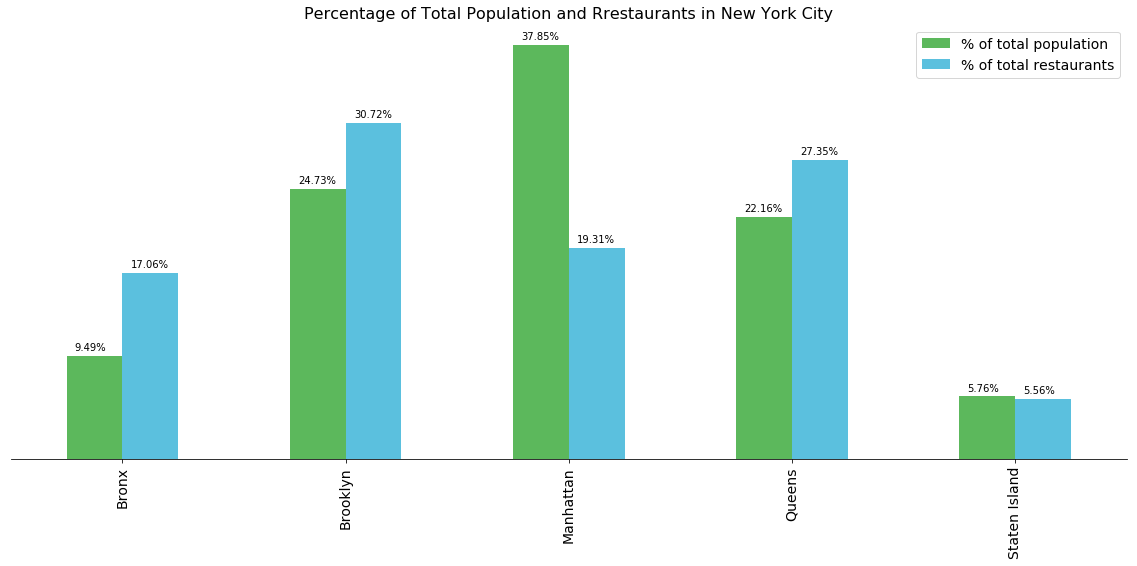

In [46]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

colors = ['#5cb85c', '#5bc0de', '#d9534f']

ax = ny_bar.plot(kind='bar',
                figsize = (20,8),
                color = colors,
                edgecolor = None)

ax.set_title("Percentage of Total Population and Rrestaurants in New York City", fontsize=16)
plt.legend(labels=ny_bar.columns,fontsize= 14)
plt.xticks(fontsize=14)

for index, spine in enumerate(plt.gca().spines.values()):
    if(index != 2):
        spine.set_visible(False)

plt.yticks([]) # IGNORE PERCENTAGE Y-AXIS

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
    ax.annotate('{}'.format(str(height) + '%'), (p.get_x()+.15*width, p.get_y() + height + 0.5))

### You should consider Brooklyn and Queens boroughs to open next restaurants. Because those boroughs have higher popluation than distribution of restaurants. Especially, Brooklyn and Queens held by themselves more than 50% of population in New York

### Hence, it is a good idea to open restaurants in Brooklyn and Queens.

## Part Two: Cluster of Neighborhoods

In this part, we will find out top trending restaurants in each neighborhood, and base on that result, we will find out cluster of neighborhoods of New York City.

You can find out the neighborhoods smiliar to your neighborhood, so you can open the next restaurants in those neighborhoods.

### Prepare for K_Means clustering by getting dummies of all Venue Category


In [47]:
my_ny_filtered.head()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,Restaurant
1,Bronx,Belmont,40.857277,-73.888452,Arthur Avenue Cafe,40.854068,-73.888838,Italian Restaurant
2,Bronx,Belmont,40.857277,-73.888452,Bella Pizza,40.854830,-73.890410,Italian Restaurant
3,Bronx,Belmont,40.857277,-73.888452,Golden City,40.854018,-73.889059,Restaurant
4,Bronx,Belmont,40.857277,-73.888452,Las Chatas,40.853850,-73.889492,Mexican Restaurant


In [48]:
ny_onehot = pd.get_dummies(my_ny_filtered[['Venue Category']], prefix="", prefix_sep="")
ny_onehot['Neighborhood'] = my_ny_filtered['Neighborhood']

In [49]:
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]
ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Belmont,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.75,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Annadale,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250000,0.000000,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Arverne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Astoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.029412,0.0,0.0,0.0,0.0,0.00,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.147059,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.088235,0.0,0.029412,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.05

### Get top 10 restaurants in each Neighbourhood

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    templist = row_categories_sorted
    # Ignore zero values, only get nonzero values
    # Sort a Series in panda python. type(templist) == Serie (True)
    templist = templist[templist>0].index.values
    
    for i in range(num_top_venues-len(templist)):
        # append '' to blank spaces instead of zeroes
        templist = np.append(templist, '')
    
    return templist[0:num_top_venues]

In [52]:
num_top_res = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Neighborhood']
for ind in np.arange(num_top_res):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_res_sorted = pd.DataFrame(columns=columns)
neighborhoods_res_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_res_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_res)

neighborhoods_res_sorted.head()

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Allerton,Chinese Restaurant,Spanish Restaurant,,,,,,,,
1,Annadale,Restaurant,American Restaurant,,,,,,,,
2,Arrochar,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,,,,,,,
3,Arverne,Thai Restaurant,,,,,,,,,
4,Astoria,Middle Eastern Restaurant,Greek Restaurant,Seafood Restaurant,Italian Restaurant,Latin American Restaurant,Indian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cajun / Creole Restaurant,Falafel Restaurant


### Check result for neighborhood: Allerton

In [53]:
templist = ny_grouped.loc[ny_grouped['Neighborhood'] == 'Allerton'].T.squeeze() # Create a Series from Panda Data Frame
templist = templist[1:] # Get rid of Neighborhood, only focus on number values
templist = templist.sort_values(ascending=False)
templist = templist[templist>0].index.values
for i in range(10-len(templist)):
    templist = np.append(templist, '')
templist

array(['Chinese Restaurant', 'Spanish Restaurant', '', '', '', '', '', '',
       '', ''], dtype=object)

### Apply K_Means Clustering

In [54]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 3, 3, 0, 3, 3, 0, 3], dtype=int32)

In [55]:
# Make ny_df have the same neighborhood as ny_grouped['Neighborhood']
ny_df = ny_data.copy()[ny_data['Neighborhood'].isin(ny_grouped['Neighborhood'])]
# Because there is some duplicates in neighborhoods and be dropped before, so it also has to be dropped in her
ny_df.drop_duplicates(['Neighborhood'], inplace=True)
ny_df.head()

,Borough,Neighborhood,Latitude,Longitude
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315


In [56]:
ny_merge = ny_df

# add clustering labels
ny_merge['Cluster Labels'] = kmeans.labels_

ny_merge = ny_merge.join(neighborhoods_res_sorted.set_index('Neighborhood'), on='Neighborhood')

In [57]:
ny_merge.reset_index(inplace=True, drop=True)
ny_merge.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Bronx,Co-op City,40.874294,-73.829939,2,Restaurant,,,,,,,,,
1,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,,,,,,
2,Bronx,Kingsbridge,40.881687,-73.902818,0,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Caribbean Restaurant,,,
3,Manhattan,Marble Hill,40.876551,-73.910660,3,American Restaurant,,,,,,,,,
4,Bronx,Woodlawn,40.898273,-73.867315,3,American Restaurant,Italian Restaurant,Indian Restaurant,,,,,,,


## Examine Clusters¶

### We will use Word Cloud to find out cluster name for each cluster


In [58]:
def get_clus_name(clus):
    places = ''
    for i in range(len(clus)):
        for place in clus.iloc[i].values.tolist():
            places += place.replace(' ', '') + ' '
    
    # Get top most restaurants in the neighborhood
    my_df = pd.DataFrame(places.split(' '))
    my_df.columns = ['Restaurant Type']
    result_list = my_df[my_df['Restaurant Type'] != '']['Restaurant Type'].value_counts()[0:3].index.values.tolist()

    return result_list

#### Test with Cluster 1

In [59]:
ny_merge.columns[list(range(5, ny_merge.shape[1]))]

Index(['1st Most Common Restaurant', '2nd Most Common Restaurant',
       '3rd Most Common Restaurant', '4th Most Common Restaurant',
       '5th Most Common Restaurant', '6th Most Common Restaurant',
       '7th Most Common Restaurant', '8th Most Common Restaurant',
       '9th Most Common Restaurant', '10th Most Common Restaurant'],
      dtype='object')

In [60]:
clus = ny_merge.loc[ny_merge['Cluster Labels'] == 0, ny_merge.columns[list(range(5, ny_merge.shape[1]))]]
places = ''
for i in range(len(clus)):
    for place in clus.iloc[i].values.tolist():
        places += place.replace(' ', '') + ' '

my_df = pd.DataFrame(places.split(' '))
my_df.columns = ['Restaurant Type']
my_df[my_df['Restaurant Type'] != '']['Restaurant Type'].value_counts()

MexicanRestaurant              13
ItalianRestaurant              13
ChineseRestaurant               9
AmericanRestaurant              9
SushiRestaurant                 8
JapaneseRestaurant              5
LatinAmericanRestaurant         5
IndianRestaurant                5
SeafoodRestaurant               5
SpanishRestaurant               5
FrenchRestaurant                5
Restaurant                      4
NewAmericanRestaurant           4
AsianRestaurant                 3
ThaiRestaurant                  3
MiddleEasternRestaurant         3
RamenRestaurant                 2
VietnameseRestaurant            2
Tex-MexRestaurant               2
FastFoodRestaurant              2
CaribbeanRestaurant             2
IsraeliRestaurant               2
MediterraneanRestaurant         1
TapasRestaurant                 1
HawaiianRestaurant              1
JewishRestaurant                1
HalalRestaurant                 1
KoreanRestaurant                1
GermanRestaurant                1
PeruvianRestau

### Get all clusters' names


In [61]:
clus_names = []

# kcluster is number of cluters

for i in range(kclusters):
    clus = ny_merge.loc[ny_merge['Cluster Labels'] == i, ny_merge.columns[list(range(5, ny_merge.shape[1]))]]
    clus_names.append(get_clus_name(clus))

clus_names

[['MexicanRestaurant', 'ItalianRestaurant', 'ChineseRestaurant'],
 ['ChineseRestaurant', 'ItalianRestaurant', 'JapaneseRestaurant'],
 ['ChineseRestaurant', 'ItalianRestaurant', 'Restaurant'],
 ['ChineseRestaurant', 'ItalianRestaurant', 'MexicanRestaurant'],
 ['ItalianRestaurant', 'MediterraneanRestaurant', 'ChineseRestaurant']]

In [62]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merge['Latitude'], ny_merge['Longitude'], ny_merge['Neighborhood'], ny_merge['Cluster Labels']):
    label = folium.Popup('Neighbourhood: ' + str(poi) + '. Trending restaurant: ' + str(clus_names[cluster-1]), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
